### Installations

In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbs
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold

## Previous Data cleaning work 

In [4]:
pd.set_option('display.max_columns', None)
# Took you dataset cleaning work Kal. Don't know if you mind
data = pd.read_csv('2012-Electricity-Consumption.csv')

orig_data = data.copy()
orig_data["TOTAL_EUI"] = orig_data["ELCNS"]/orig_data["SQFT"]

data = data.iloc[:,1:445].copy()
data_extra = orig_data.iloc[:,1093:1103].copy()
data = data.merge(data_extra, how='outer', left_index=True, right_index=True)
data["ELEXP"] = orig_data["ELEXP"].copy()
print("Shape of original data: ", orig_data.shape)
print("Shape of original selected data: ", data.shape)

cat = []
cont = []
keep = []
for col in data.columns:
  temp = keep[:]
  temp.append(col)
  if len(data[data.columns.intersection(temp)].dropna()) <= 3000:
    continue
  keep.append(col)
  if len(data[col].unique()) <= 54:
    cat.append(col)
  else:
    cont.append(col)

data = data[keep].copy()


data["TOTAL_EUI"]= orig_data["TOTAL_EUI"].copy()
data.reset_index()
data = data.dropna()

# # Dropping outliers
# Q1 = data['TOTAL_EUI'].quantile(0.25)
# Q3 = data['TOTAL_EUI'].quantile(0.75)
# IQR = Q3 - Q1
# # Filtering values between Q1-1.5IQR and Q3+1.5IQR
# data = data.query('(@Q1 - 1.5 * @IQR) <= TOTAL_EUI <= (@Q3 + 1.5 * @IQR)')

y = data["TOTAL_EUI"].copy()
data = data.drop("SQFT", axis=1)
data = data.drop("TOTAL_EUI", axis=1)
print("Shape of kept data: ", data.shape)


for feature in cat:
  data[feature] = data[feature].astype(str)

one_hot = pd.get_dummies(data, prefix=cat)
print("Shape of one-hot-encode: ", one_hot.shape)

Shape of original data:  (6720, 1120)
Shape of original selected data:  (6720, 455)
Shape of kept data:  (3009, 125)
Shape of one-hot-encode:  (3009, 469)


### Feature Selection using Lasso 

In [72]:
train_data, valid_data, y_train, y_valid = train_test_split(one_hot, y, test_size=.30, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', Lasso())
])

search = GridSearchCV(pipeline, {'model__alpha': np.arange(0.1, 5, 0.01)}, 
                                    cv = 5,
                                    scoring = 'neg_mean_squared_error', 
                                    verbose = 3)

lasso = np.array(search.fit(train_data, y_train))

# the best value for alpha
print(search.best_params_)

Fitting 5 folds for each of 490 candidates, totalling 2450 fits
[CV 1/5] END ...............model__alpha=0.1;, score=-155.199 total time=   0.1s
[CV 2/5] END ...............model__alpha=0.1;, score=-241.889 total time=   0.1s
[CV 3/5] END ...............model__alpha=0.1;, score=-212.067 total time=   0.1s
[CV 4/5] END ..............model__alpha=0.1;, score=-1230.798 total time=   0.1s
[CV 5/5] END ...............model__alpha=0.1;, score=-243.178 total time=   0.1s
[CV 1/5] END ..............model__alpha=0.11;, score=-153.744 total time=   0.1s
[CV 2/5] END ..............model__alpha=0.11;, score=-241.321 total time=   0.1s
[CV 3/5] END ..............model__alpha=0.11;, score=-211.996 total time=   0.1s
[CV 4/5] END .............model__alpha=0.11;, score=-1211.561 total time=   0.1s
[CV 5/5] END ..............model__alpha=0.11;, score=-242.374 total time=   0.1s
[CV 1/5] END ..............model__alpha=0.12;, score=-152.387 total time=   0.1s
[CV 2/5] END ..............model__alpha=0.12;

In [99]:
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)
feature_indices = [important for important, value in enumerate(importance > 0) if value]
#Columns that were removed were: 
# WKRHS, LAPTPN, PBA, RFTILT, 
selected_features = one_hot.iloc[:, feature_indices]
selected_features.shape

(3009, 36)

## Lasso Graph

Text(0.5, 1.0, 'Lasso coefficients as a function of alpha')

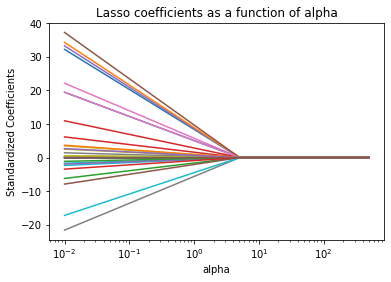

In [76]:
train_data, valid_data, train_y, valid_y = train_test_split(selected_features, y, test_size=.30, random_state=42)

alphas = np.linspace(0.01,500,100)
lasso = Lasso(max_iter=10000)
coefs = []
mse_train_list = []
mse_valid = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(train_data, train_y)
    coefs.append(lasso.coef_)
    y_hat = lasso.predict(train_data)
    mse_train = mean_squared_error(train_y, y_hat)
    mse_train_list.append(mse_train)
    y_hat = lasso.predict(valid_data)
    mse_v = mean_squared_error(valid_y, y_hat)
    mse_valid.append(mse_v)
    
    

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha')

# Models

In [78]:
x_train, x_valid, y_train, y_valid = train_test_split(selected_features, y, test_size=.30, random_state=42)

### CATBOOST

In [79]:
import catboost as cb 

train_dataset = cb.Pool(x_train, y_train)
test_dataset = cb.Pool(x_valid, y_valid)

model_cat = cb.CatBoostRegressor(loss_function='RMSE')

grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model_cat.grid_search(grid, train_dataset)

pred = model_cat.predict(x_valid)
rmse = (np.sqrt(mean_squared_error(y_valid, pred)))
r2 = r2_score(y_valid, pred)
print("Testing performance")
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))




0:	learn: 27.7111584	test: 27.5527681	best: 27.5527681 (0)	total: 7.18ms	remaining: 711ms
1:	learn: 27.2543322	test: 27.0539379	best: 27.0539379 (1)	total: 9.93ms	remaining: 487ms
2:	learn: 26.7423227	test: 26.4852701	best: 26.4852701 (2)	total: 12.6ms	remaining: 406ms
3:	learn: 26.3017411	test: 26.0168882	best: 26.0168882 (3)	total: 14.2ms	remaining: 342ms
4:	learn: 25.8959403	test: 25.5735144	best: 25.5735144 (4)	total: 15.8ms	remaining: 300ms
5:	learn: 25.4718279	test: 25.0723026	best: 25.0723026 (5)	total: 19.1ms	remaining: 299ms
6:	learn: 25.0720790	test: 24.6302697	best: 24.6302697 (6)	total: 20.1ms	remaining: 267ms
7:	learn: 24.6952675	test: 24.1978128	best: 24.1978128 (7)	total: 20.9ms	remaining: 240ms
8:	learn: 24.3224128	test: 23.7501990	best: 23.7501990 (8)	total: 22.6ms	remaining: 228ms
9:	learn: 23.9714448	test: 23.3438217	best: 23.3438217 (9)	total: 23.8ms	remaining: 215ms
10:	learn: 23.6643956	test: 23.0036511	best: 23.0036511 (10)	total: 24.7ms	remaining: 200ms
11:	lear

### Lightgbm

In [80]:
import lightgbm as lgb

# lgb_train = lgb.Dataset(x_train, y_train)
# lgb_eval = lgb.Dataset(x_valid, y_valid)

# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': {'l2', 'l1'},
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0
# }

# print('Starting training...')
# # train
# gbm = lgb.train(params,
#                 lgb_train,
#                 num_boost_round=20,
#                 valid_sets=lgb_eval,
#                 callbacks=[lgb.early_stopping(stopping_rounds=5)])

# # print('Saving model...')
# # # save model to file
# # gbm.save_model('model.txt')

# print('Starting predicting...')
# # predict
# y_pred = gbm.predict(x_valid, num_iteration=gbm.best_iteration)
# # eval
# rmse_test = mean_squared_error(y_valid, y_pred) ** 0.5
# print(f'The RMSE of prediction is: {rmse_test}')

model_lgb = lgb.LGBMRegressor()
model_lgb.fit(x_train, y_train)


LGBMRegressor()

### XGBoost

In [81]:
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

# define model
model_xgbr = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
model_xgbr.fit(x_train, y_train)


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

## KFold to Compare Models

To compare models fairly and not to have misevaluated $R^2$'s we will be applying adjusted $R^2$. Adjusted $R^2$ takes into conisderation the amount of features and makes sure to penalize those models that apply more features. Hence, we will have a better evaluation on what model is actually improving. 

In [82]:
################################
# for model comparisons
################################
def compute_Kfold_r2(model, X, Y):
    cv = KFold(n_splits=5,shuffle=True,random_state=45)
    r2 = make_scorer(r2_score)
    r2_val_score = cross_val_score(model, X, Y, cv=cv,scoring=r2)
    scores=[r2_val_score.mean()]
    return scores

##################################
# parameters: 
# r2 : the r2 score of the model 
# n: the number of samples
# f: the number of feauteres
# returns: adjusted_r2
#################################
def compute_adjusted_r2(R2, n, f): 
    adj_r2 = 1-(1-R2)*(n-1)/(n-f-1)
    return adj_r2


### CATBOOST Adjusted_r2

In [83]:
n, f = x_train.shape[0], x_train.shape[1]
score = compute_Kfold_r2(model_cat, x_train, y_train)[0]
print(compute_adjusted_r2(score,n, f ))

0:	learn: 21.4600666	total: 2.81ms	remaining: 279ms
1:	learn: 20.7304197	total: 5.09ms	remaining: 250ms
2:	learn: 20.0229532	total: 6.77ms	remaining: 219ms
3:	learn: 19.3990968	total: 7.73ms	remaining: 185ms
4:	learn: 18.8037959	total: 8.87ms	remaining: 168ms
5:	learn: 18.2671021	total: 11.5ms	remaining: 181ms
6:	learn: 17.8039804	total: 12.5ms	remaining: 166ms
7:	learn: 17.3564443	total: 13.4ms	remaining: 154ms
8:	learn: 17.0573616	total: 14.2ms	remaining: 143ms
9:	learn: 16.6955061	total: 15.1ms	remaining: 136ms
10:	learn: 16.4645916	total: 16.3ms	remaining: 132ms
11:	learn: 16.1750135	total: 17.7ms	remaining: 129ms
12:	learn: 15.8800871	total: 19ms	remaining: 127ms
13:	learn: 15.6220483	total: 20.1ms	remaining: 123ms
14:	learn: 15.3898553	total: 20.9ms	remaining: 119ms
15:	learn: 15.2450878	total: 21.7ms	remaining: 114ms
16:	learn: 15.0719119	total: 22.4ms	remaining: 109ms
17:	learn: 14.8653175	total: 23.2ms	remaining: 106ms
18:	learn: 14.7351159	total: 24ms	remaining: 102ms
19:	lea

### Lightgmb adjusted R2

In [84]:
n, f = x_train.shape[0], x_train.shape[1]
score = compute_Kfold_r2(model_lgb, x_train, y_train)[0]
print(compute_adjusted_r2(score,n, f ))

0.5644925312087964


### XGBoost Adjusted R2

In [85]:
n, f = x_train.shape[0], x_train.shape[1]
score = compute_Kfold_r2(model_xgbr, x_train, y_train)[0]
print(compute_adjusted_r2(score,n, f ))

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


0.5432094000905763


## Shap Evaluation

### CatBoost Shap Values

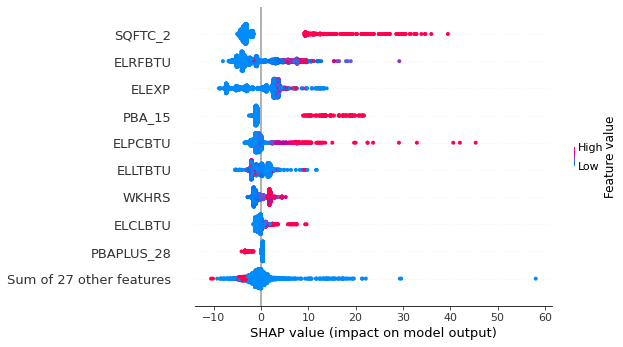

In [87]:
import shap

explainer = shap.Explainer(model_cat)
shap_values = explainer(x_train)
shap.plots.beeswarm(shap_values)

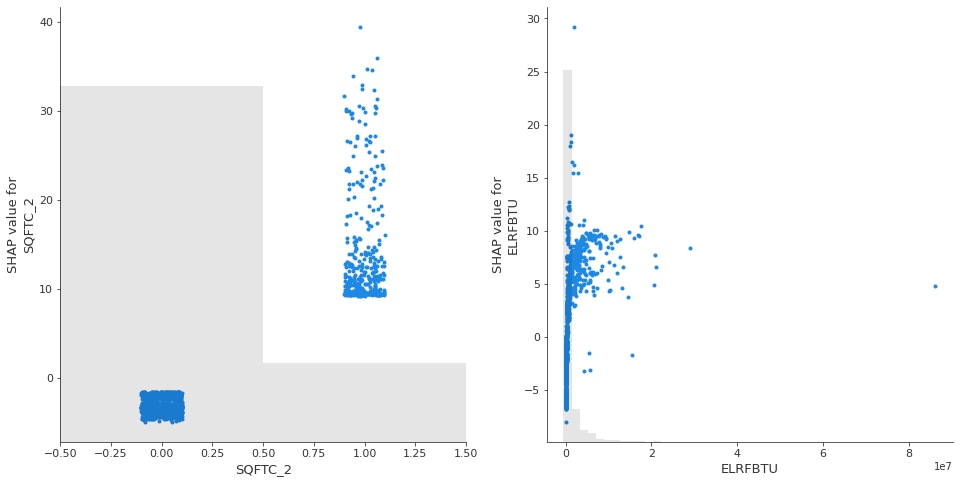

In [92]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 8))

#Shap scatter plots
shap.plots.scatter(shap_values[:, 'SQFTC_2'], ax=ax[0], show = False)
shap.plots.scatter(shap_values[:, 'ELRFBTU'], ax = ax[1])

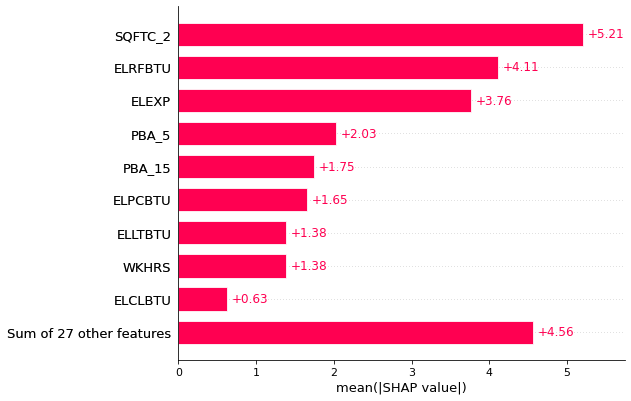

In [93]:
shap.plots.bar(shap_values)

### LightGMB Shap Values

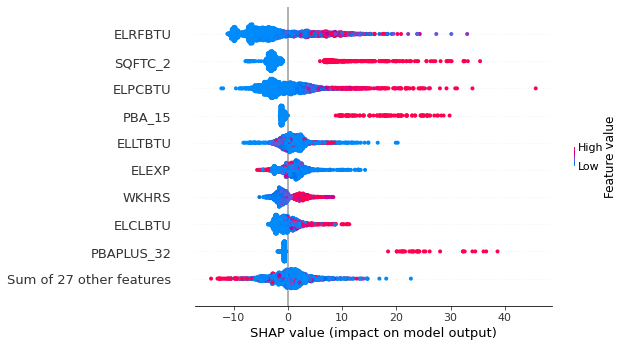

In [96]:
explainer = shap.Explainer(model_lgb)
shap_values = explainer(x_train)
shap.plots.beeswarm(shap_values)

### XGBoost Shap Values

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


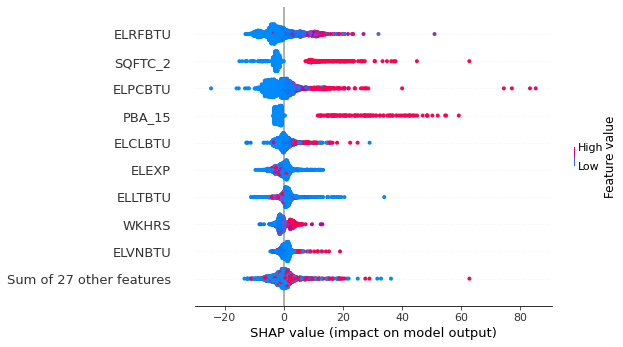

In [97]:
explainer = shap.Explainer(model_xgbr)
shap_values = explainer(x_train)
shap.plots.beeswarm(shap_values)

## RandomForest

In [104]:
from sklearn.ensemble import RandomForestRegressor
#x_train, x_valid, y_train, y_valid
model_rf = RandomForestRegressor()

model_rf.fit(x_train, y_train)

model_rf.score(x_valid, y_valid) 


0.6535502403173818

In [105]:
n, f = x_train.shape[0], x_train.shape[1]
score = compute_Kfold_r2(model_rf, x_train, y_train)[0]
print(compute_adjusted_r2(score,n, f ))

0.5770854866692885


### Distribution Plot

count    3009.000000
mean       18.433763
std        20.838216
min         0.000000
25%         6.425609
50%        12.621715
75%        22.752569
max       227.639028
Name: TOTAL_EUI, dtype: float64

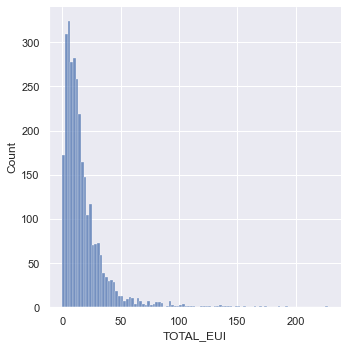

In [5]:
sbs.set(style="darkgrid")

sbs.displot(y, bins=100)
y.describe()